<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/%D0%A0_%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD_1_%D0%BC_%D0%BA%D0%B0%D0%BA%D0%B3%D0%BB_%D0%9D%D0%B8%D0%BA%D0%B8%D1%82%D0%B0_%D0%A8%D1%83%D0%B1%D0%B8%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras import  Model, Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from kerastuner.tuners import BayesianOptimization, Hyperband

Found 3427 images belonging to 3 classes.


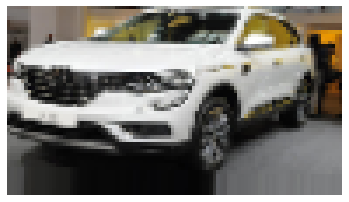

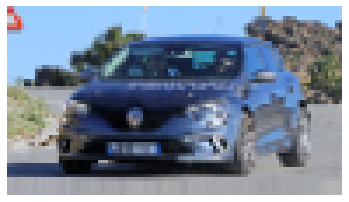

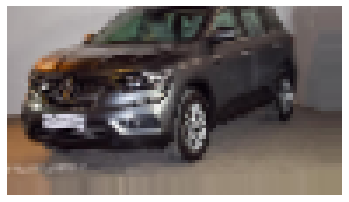

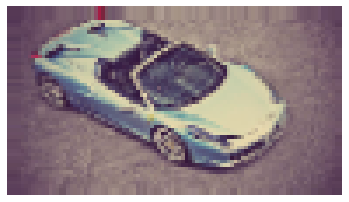

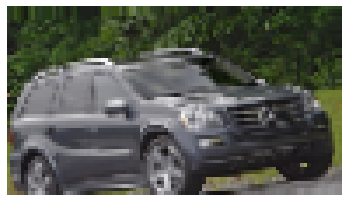

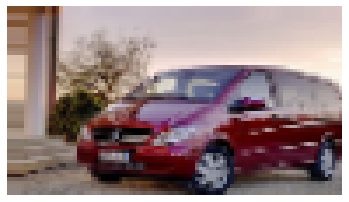

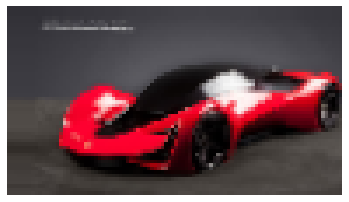

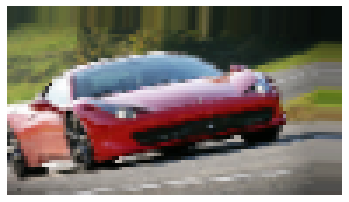

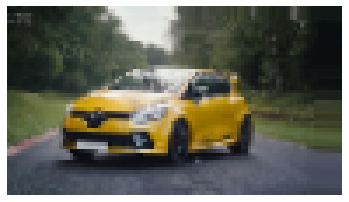

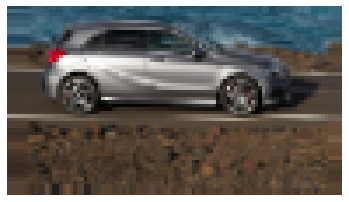

1372

In [0]:
batch_size = 64 # 128
validation_split = 0.2


# Тестовая выборка
x_test = np.load('F:\kaggle_1\pics_file.npy')

# Размер изображений
target_size = x_test.shape[2], x_test.shape[1]

# Загрузка датасета
dg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
imagegen = dg.flow_from_directory(batch_size=100000000, directory='F:\kaggle_1\middle_fmr', target_size=target_size)
x, y = next(imagegen)

# Разделение на train и test
x_train, x_val, y_train, y_val  = train_test_split(x, y, test_size=validation_split)

x_val = np.concatenate((x_val,x_val[:,:,::-1,:]), 0)
y_val = np.concatenate((y_val,y_val), 0)

train_dg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                           rotation_range=3,
                                                           zoom_range=0.1,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1)
val_dg   = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

train_imagegen = train_dg.flow(x_train, y_train, batch_size=batch_size)
val_imagegen   =   val_dg.flow(x_val  , y_val  , batch_size=batch_size)

tmp, _ = next(train_imagegen)
for image in tmp[:10,:,:,:]:
    plt.imshow(image)
    plt.axis(False)
    plt.show()

train_len = x_train.shape[0]
val_len   = x_val  .shape[0]
val_len

In [0]:
model = Sequential([layers.Input(shape=list(target_size) + [3])], name='test')
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.SpatialDropout2D(0.1))

print(model.output_shape)

model.add(layers.MaxPool2D((2,3)))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.SpatialDropout2D(0.1))

print(model.output_shape)

model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.SpatialDropout2D(0.1))

print(model.output_shape)

model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(512, 3, padding='valid', activation='relu'))
model.add(layers.SpatialDropout2D(0.1))

print(model.output_shape)

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1500, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))
model.add(layers.Dense(3, activation='softmax'))

model.compile(Adam(1e-4), 'categorical_crossentropy', ['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(None, 50, 92, 512)
(None, 21, 26, 512)
(None, 6, 9, 512)
(None, 1, 2, 512)


In [0]:
model.compile(Adam(1e-5), 'categorical_crossentropy', ['accuracy'])
model.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 52, 94, 512)       14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 92, 512)       2359808   
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 50, 92, 512)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 30, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 28, 512)       2359808   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 26, 512)       2359808   
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 21, 26, 512)       0      

In [0]:
hist = model.fit(train_imagegen, steps_per_epoch=train_len//batch_size, epochs=120,
                 validation_data = (x_val, y_val),
                 verbose=2)


Epoch 1/120
42/42 - 80s - loss: 1.3119 - acc: 0.4442 - val_loss: 1.0988 - val_acc: 0.3134
Epoch 2/120
42/42 - 77s - loss: 1.2116 - acc: 0.4796 - val_loss: 1.1002 - val_acc: 0.3134
Epoch 3/120
42/42 - 77s - loss: 1.1587 - acc: 0.4826 - val_loss: 1.1001 - val_acc: 0.3134
Epoch 4/120
42/42 - 78s - loss: 1.1367 - acc: 0.5004 - val_loss: 1.1047 - val_acc: 0.3134
Epoch 5/120
42/42 - 76s - loss: 1.1001 - acc: 0.5075 - val_loss: 1.1019 - val_acc: 0.3134
Epoch 6/120
42/42 - 77s - loss: 1.0805 - acc: 0.5073 - val_loss: 1.1005 - val_acc: 0.3134
Epoch 7/120
42/42 - 77s - loss: 1.0859 - acc: 0.5043 - val_loss: 1.1098 - val_acc: 0.3134
Epoch 8/120
42/42 - 77s - loss: 1.0591 - acc: 0.5009 - val_loss: 1.1070 - val_acc: 0.3134
Epoch 9/120
42/42 - 77s - loss: 1.0302 - acc: 0.5282 - val_loss: 1.0881 - val_acc: 0.3134
Epoch 10/120
42/42 - 72s - loss: 1.0148 - acc: 0.5342 - val_loss: 1.0860 - val_acc: 0.3134
Epoch 11/120
42/42 - 78s - loss: 1.0196 - acc: 0.5283 - val_loss: 1.1093 - val_acc: 0.3134
Epoch 12

#Подбор гиперпараметров

Изначально в архитектуре был подбор параметорв NASnet (https://keras.io/applications/#nasnet)

In [0]:
def build_model(hp=None):
    if hp:
        drop1 = hp.Float('drop1', 0.005, 0.35)
        units = hp.Int('units', min_value=10, max_value=1500, step=10)
        drop2 = hp.Float('drop2', 0.001, 0.1 )
    else:
        drop1 = 0.2
        drop2 = 0.1
        units = 200
    
    name = "%f_%d_%f" % (drop1,units,drop2)
    print('='*10, name, '='*10)
    
    model = Sequential([layers.Input(shape=tmp.shape[1:])], name=name)
    if drop1:
        model.add(layers.SpatialDropout2D(drop1))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units, activation='relu'))
    if drop2:
        model.add(layers.Dropout(drop2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(Adam(1e-5), 'categorical_crossentropy', ['accuracy'])
    return model

model = build_model()
model.summary()

========== 0.200000_200_0.100000 ==========
Model: "0.200000_200_0.100000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout2d_1 (Spatial (None, 54, 96, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15552)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15552)             62208     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               3110600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
d

In [0]:
cbs = []
cbs.append(EarlyStopping    (monitor='val_acc', patience=10))
cbs.append(ReduceLROnPlateau('val_loss', patience=3))

tuner = BayesianOptimization(build_model, 'val_acc', 20)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [0]:
# Поиск оптимума
tuner.search(train_imagegen, steps_per_epoch=train_len//batch_size, epochs=12,
             validation_data = (x_val, y_val),
             verbose=0,
             callbacks=cbs)

========== 0.325246_520_0.051731 ==========


========== 0.159244_840_0.049538 ==========


========== 0.144655_920_0.055139 ==========


========== 0.297772_400_0.076631 ==========


========== 0.092633_1500_0.041224 ==========


========== 0.264550_390_0.073037 ==========


========== 0.322360_1120_0.019372 ==========


========== 0.251493_90_0.006771 ==========


========== 0.045465_880_0.010272 ==========


========== 0.034729_860_0.049204 ==========


========== 0.062909_1450_0.092039 ==========


========== 0.095329_1320_0.075913 ==========


========== 0.256244_940_0.002681 ==========


========== 0.271769_1450_0.041116 ==========


========== 0.324240_120_0.023704 ==========


========== 0.132990_1370_0.022858 ==========


========== 0.117983_400_0.050566 ==========


In [0]:
model = build_model()
history = model.fit(train_imagegen, steps_per_epoch=train_len//batch_size, epochs=12,
                    validation_data = (x_val, y_val),
                    verbose=2)

========== 0.200000_200_0.300000 ==========
Epoch 1/12
42/42 - 6s - loss: 1.3503 - acc: 0.4046 - val_loss: 1.0421 - val_acc: 0.4497
Epoch 2/12
42/42 - 5s - loss: 1.2313 - acc: 0.4371 - val_loss: 1.0013 - val_acc: 0.4927
Epoch 3/12
42/42 - 5s - loss: 1.1966 - acc: 0.4621 - val_loss: 0.9947 - val_acc: 0.4993
Epoch 4/12
42/42 - 5s - loss: 1.1925 - acc: 0.4666 - val_loss: 1.0058 - val_acc: 0.5000
Epoch 5/12
42/42 - 5s - loss: 1.2044 - acc: 0.4557 - val_loss: 1.0018 - val_acc: 0.5036
Epoch 6/12
42/42 - 5s - loss: 1.1839 - acc: 0.4845 - val_loss: 0.9998 - val_acc: 0.5058
Epoch 7/12
42/42 - 5s - loss: 1.1783 - acc: 0.4763 - val_loss: 0.9882 - val_acc: 0.5226
Epoch 8/12
42/42 - 5s - loss: 1.1869 - acc: 0.4479 - val_loss: 0.9856 - val_acc: 0.5182
Epoch 9/12
42/42 - 5s - loss: 1.1605 - acc: 0.4718 - val_loss: 0.9849 - val_acc: 0.5219
Epoch 10/12
42/42 - 5s - loss: 1.1322 - acc: 0.4871 - val_loss: 0.9824 - val_acc: 0.5146
Epoch 11/12
42/42 - 5s - loss: 1.1498 - acc: 0.4769 - val_loss: 0.9639 - va

In [0]:
best_model = tuner.get_best_models(num_models=1)[0]

========== 0.090107_1120_0.061019 ==========


In [0]:
loss, acc = best_model.evaluate(x_val, y_val)
print("Точность модели: {}".format(acc))

1372/1372 [==============================] loss: 0.8921 - acc: 0.6050
Точность модели: 0.6049562692642212
